<a href="https://colab.research.google.com/github/JakeOh/202505_BD50/blob/main/lab_da/ml17_ann_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST 이미지 분류

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

In [2]:
tf.__version__

'2.19.0'

In [3]:
keras.__version__

'3.10.0'

In [4]:
print(keras.config.backend())  # Keras 라이브러리에서 신경망 계산을 할 때 필요한 라이브러리.

tensorflow


In [5]:
print(tf.config.list_physical_devices())  # CPU/GPU/TPU 사용 여부 확인

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Keras 라이브러리는 GPU 연산을 직접 수행하지 않음. 대신에 GPU 연산을 수행하는 다른 딥러닝 라이브러리를 백엔드(backend)로 활용함.

*   Keras에서 사용할 수 있는 백엔드 종류
    *   TensorFlow - Google에서 만든 텐서(Tensor) 연산을 빠르게 수행하기 위한 라이브러리.
    *   PyTorch - Meta(페이스북)에서 만든 딥러닝 라이브러리 -> 리눅스 재단으로 오픈소스로 공개.
*   Keras
    *   여러가지 백엔드를 사용해서 신경망을 쉽게 만들고 사용할 수 있도록 만든 고급 라이브러리.
    *   2.3.1 버전 이후부터는 TensorFlow만 단일 백엔드로 사용하도록 기능 변경.
    *   3.0 버전부터 다시 멀티 백엔드 정책으로 바뀜.

# Fashion MNIST 데이터 셋

10가지 패션 아이템의 28x28 크기의 흑백 이미지 60,000개 훈련 셋/레이블, 10,000개 테스트 셋/레이블.

In [6]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
# (훈련 셋, 훈련 레이블), (테스트 셋, 테스트 레이블)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
x_train.shape  # (n_samples, image_width, image_height)

(60000, 28, 28)

In [8]:
y_train.shape

(60000,)

In [9]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

In [10]:
x_test.shape

(10000, 28, 28)

In [11]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

훈련셋, 테스트셋 모두 각 클래스의 샘플들이 동일한 개수로 만들어져 있음.

데이터셋의 이미지를 시각화해 보세요.

In [12]:
def plot_fashion_mnist(arr, ncols=10):
    # arr: (samples, width, height) shape의 3차원 배열
    # ncols: subplot axis의 컬럼 개수.
    n = len(arr)  # 출력할 이미지 개수
    nrows = int(np.ceil(n / ncols))  # subplot Axis 행 개수.
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols, nrows))
    for i in range(nrows):
        for j in range(ncols):
            idx = i * ncols + j  # arr에서 선택할 이미지 인덱스.
            if nrows == 1 or ncols == 1:  # ax가 1차원 배열인 경우
                if idx < n:
                    ax[idx].imshow(arr[idx], cmap=plt.cm.binary)
                ax[idx].axis('off')
            else:  # ax가 2차원 배열인 경우
                if idx < n:
                    ax[i, j].imshow(arr[idx], cmap=plt.cm.binary)
                ax[i, j].axis('off')
    plt.show()

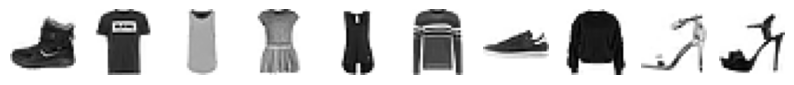

In [13]:
plot_fashion_mnist(x_train[:10])

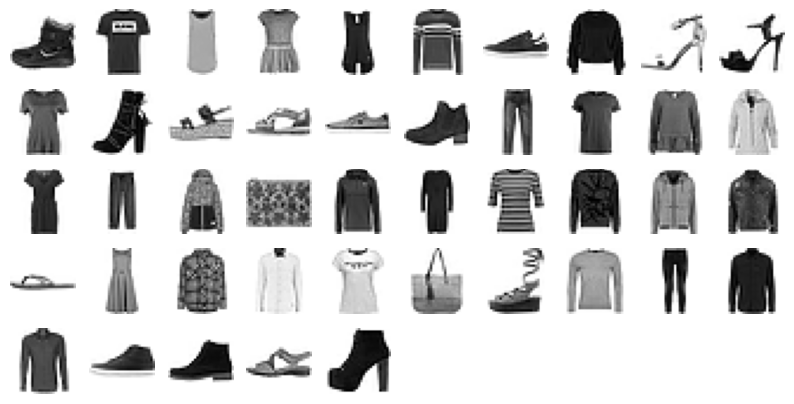

In [14]:
plot_fashion_mnist(x_train[:45])

# 훈련 셋/레이블을 훈련 셋과 검증 셋으로 분리

In [15]:
train_data, val_data, train_target, val_target = \
        train_test_split(x_train, y_train, random_state=42, test_size=0.2, stratify=y_train)

In [16]:
print(train_data.shape)
print(train_target.shape)
print(np.unique(train_target, return_counts=True))

(48000, 28, 28)
(48000,)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800]))


In [17]:
print(val_data.shape)
print(val_target.shape)
print(np.unique(val_target, return_counts=True))

(12000, 28, 28)
(12000,)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200]))


# SGD Classifier

In [18]:
train_data[0]  #> 각 픽셀의 값들이 0(white) ~ 255(white)

array([[  0,   0,   0,   0,   1,   1,   0,   0,   0,  25,  55,   0,   0,
          0,   0,   0,   0,  43,  24,   0,   0,   0,   1,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   1,   1,   1,   0,  25, 147, 189, 181,  96,  51,
         49,  55,  37,  76, 217, 172, 125,  20,   0,   2,   1,   0,   0,
          0,   0],
       [  0,   0,   0,   1,   3,   0,  82, 206, 202, 190, 178, 188, 239,
        152,  99, 199, 201, 162, 176, 192, 185,  71,   0,   2,   0,   0,
          0,   0],
       [  0,   0,   0,   1,   0,   0, 202, 196, 181, 188, 183, 169, 179,
        160, 107, 198, 166, 167, 178, 170, 183, 166,   0,   0,   1,   0,
          0,   0],
       [  0,   0,   0,   1,   0,  48, 216, 184, 185, 185, 190, 175, 164,
        188, 198, 188, 157, 183, 176, 171, 167, 175,  26,   0,   2,   0,
          0,   0],
       [  0,   0,   0,   0,   0,  90, 224, 183, 185, 184, 183, 190, 164,
        169, 193, 158, 170, 174, 176, 175, 165, 180,  62,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 123, 228, 184, 180, 183, 178, 183, 172,
        172, 172, 161, 179, 170, 174, 175, 165, 181, 106,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 156, 229, 188, 175, 178, 175, 175, 190,
        157, 157, 180, 169, 169, 172, 171, 161, 179, 143,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 181, 228, 190, 174, 174, 176, 175, 197,
        167, 167, 183, 166, 169, 171, 170, 162, 175, 172,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   6, 175, 221, 192, 170, 174, 176, 175, 193,
        176, 172, 175, 167, 169, 169, 167, 160, 169, 196,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,  23, 184, 216, 206, 164, 175, 176, 175, 192,
        178, 175, 174, 167, 166, 169, 169, 165, 169, 175,   6,   0,   0,
          0,   0],
       [  0,   0,   0,   0,  53, 189, 208, 219, 161, 176, 176, 175, 190,
        181, 178, 172, 169, 165, 170, 169, 166, 167, 183,  26,   0,   0,
          0,   0],
       [  0,   0,   0,   0,  84, 194, 207, 216, 157, 176, 175, 176, 193,
        183, 180, 172, 167, 167, 166, 170, 165, 167, 185,  61,   0,   0,
          0,   0],
       [  0,   0,   0,   0, 114, 193, 211, 207, 157, 175, 175, 176, 196,
        183, 181, 172, 166, 166, 165, 170, 164, 169, 187,  88,   0,   0,
          0,   0],
       [  0,   0,   0,   0, 155, 192, 219, 194, 161, 172, 178, 176, 197,
        185, 181, 169, 166, 165, 165, 171, 164, 171, 184, 108,   0,   0,
          0,   0],
       [  0,   0,   0,   0, 181, 192, 225, 185, 162, 172, 179, 176, 199,
        185, 183, 169, 166, 164, 164, 172, 161, 170, 184, 135,   0,   0,
          0,   0],
       [  0,   0,   0,   0, 210, 189, 233, 180, 161, 171, 179, 179, 201,
        185, 190, 166, 166, 164, 164, 176, 158, 171, 183, 155,   0,   0,
          0,   0],
       [  0,   0,   0,   0, 229, 184, 234, 176, 164, 169, 180, 183, 198,
        185, 193, 166, 167, 164, 165, 179, 157, 176, 179, 174,   0,   0,
          0,   0],
       [  0,   0,   0,   2, 237, 183, 237, 171, 166, 167, 178, 188, 196,
        187, 196, 164, 166, 165, 166, 179, 157, 178, 176, 185,   2,   0,
          0,   0],
       [  0,   0,   0,  24, 246, 184, 255, 172, 166, 169, 180, 192, 196,
        189, 201, 161, 164, 165, 165, 181, 161, 181, 176, 189,  17,   0,
          0,   0],
       [  0,   0,   0,  52, 247, 187, 238, 166, 170, 170, 180, 198, 193,
        189, 207, 160, 165, 165, 164, 180, 162, 187, 175, 192,  52,   0,
          0,   0],
       [  0,   0,   0,  82, 215, 192, 239, 158, 169, 174, 179, 207, 189,
        187, 213, 160, 167, 166, 165, 181, 169, 190, 170, 192,  73,   0,
          0,   0],
       [  0,   0,   0, 102, 212, 201, 212, 166, 169, 171, 179, 217, 189,
        187, 217, 157, 170, 167, 166, 178, 171, 196, 169, 171,  84,   0,
          0,   0],
       [  0,   0,   0, 166, 211, 213, 193, 164, 170, 170, 180, 226, 181,
        187, 228, 157, 167, 167, 158, 188, 196, 128, 170, 179, 128,   0,
          0,   0],
       [  0,   0,   0,  35,  92, 129, 19

In [19]:
# 훈련 셋의 픽셀 값을 0 ~ 1 사이의 값으로 스케일링 -> 확률적 경사 하강법 성능을 높이기 위해서.
train_data_scaled = train_data / 255.0

In [20]:
train_data_scaled[0]

array([[0.        , 0.        , 0.        , 0.        , 0.00392157,
        0.00392157, 0.        , 0.        , 0.        , 0.09803922,
        0.21568627, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.16862745, 0.09411765, 0.        ,
        0.        , 0.        , 0.00392157, 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00392157, 0.00392157,
        0.00392157, 0.        , 0.09803922, 0.57647059, 0.74117647,
        0.70980392, 0.37647059, 0.2       , 0.19215686, 0.21568627,
        0.14509804, 0.29803922, 0.85098039, 0.6745098 , 0.49019608,
        0.07843137, 0.        , 0.00784314, 0.00392157, 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00392157, 0.01176471,
        0.        , 0.32156863, 0.80784314, 0.79215686, 0.74509804,
        0.69803922, 0.7372549 , 0.9372549 , 0.59607843, 0.38823529,
        0.78039216, 0.7882

In [21]:
sgd = SGDClassifier(loss='log_loss', random_state=42, n_jobs=-1)

In [22]:
sgd.fit(X=train_data_scaled.reshape((48_000, -1)), y=train_target)

SGDClassifier(loss='log_loss', n_jobs=-1, random_state=42)

In [23]:
sgd.intercept_  #> shape: (10,)

array([ -1.54024535,  -4.97085256,  -2.45411884,  -1.5496291 ,
        -4.94592029,   3.66151889,  -1.47955462,  -1.90241534,
        -4.40078057, -25.19876253])

In [24]:
sgd.coef_.shape  #> (10, 784)

(10, 784)

In [25]:
predict_probas = sgd.predict_proba(X=train_data_scaled.reshape((48_000, -1)))

In [26]:
predict_probas.shape  #> (48_000, 10)

(48000, 10)

In [27]:
predict_probas[:5]

array([[1.20888251e-02, 1.05549631e-05, 2.30094285e-01, 3.41231387e-03,
        4.86284532e-02, 3.96063160e-10, 6.91742929e-01, 1.54454383e-17,
        1.40226378e-02, 1.05805064e-16],
       [7.53889861e-01, 1.20438290e-04, 4.89841116e-05, 2.88644150e-04,
        7.52168267e-02, 4.15812599e-17, 1.69806662e-01, 2.22627871e-15,
        6.28584469e-04, 3.41774283e-15],
       [2.89450403e-03, 2.51542365e-04, 1.32250305e-04, 9.78121334e-01,
        2.43557068e-04, 8.15414752e-12, 1.83430550e-02, 1.32044303e-06,
        1.24368179e-05, 1.15226778e-10],
       [1.87927047e-02, 1.53865511e-02, 4.75084700e-03, 9.59873842e-01,
        2.15421676e-04, 2.30937550e-07, 4.85837345e-04, 7.79498173e-08,
        4.94463323e-04, 2.39574997e-08],
       [9.71611164e-01, 8.55700455e-07, 2.35430174e-03, 2.77866962e-07,
        7.27359445e-06, 2.50343665e-19, 2.58251753e-02, 6.13245802e-16,
        2.00951140e-04, 2.02813751e-10]])

In [28]:
predicts = sgd.predict(X=train_data_scaled.reshape((48_000, -1)))

In [29]:
predicts.shape  #> (48_000,)

(48000,)

In [30]:
predicts[:5]

array([6, 0, 3, 3, 0], dtype=uint8)

In [31]:
accuracy_score(train_target, predicts)  # 훈련 셋 정확도

0.8518125

In [32]:
# 검증 셋의 모든 픽셀을 0 ~ 1 사이로 스케일링
val_data_scaled = val_data / 255.0
# 검증 셋의 예측값
val_predicts = sgd.predict(X=val_data_scaled.reshape((12_000, -1)))
# 검증 셋의 정확도
accuracy_score(y_true=val_target, y_pred=val_predicts)

0.8468333333333333

# 신경망

Keras 라이브러리를 사용해서 입력층과 출력층만 갖는 신경망을 만들고 테스트하세요.

In [33]:
tr_data_scaled_flat = train_data_scaled.reshape((48_000, -1))  #> shape: (48_000, 784)
val_data_scaled_flat = val_data_scaled.reshape((12_000, -1))   #> shape: (12_000, 784)

In [34]:
print(tr_data_scaled_flat.shape)
print(val_data_scaled_flat.shape)

(48000, 784)
(12000, 784)


In [35]:
inputs = keras.layers.Input(shape=(784,))  # 입력층

In [36]:
dense = keras.layers.Dense(units=10, activation='softmax')  # 출력층

In [37]:
model = keras.Sequential(layers=[inputs, dense])  # 완전 연결 신경망

In [38]:
model.summary()
#> 모델 파라미터 개수 = (784 weight * 10 output) + 10 bias =  7,850

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [40]:
model.fit(x=tr_data_scaled_flat, y=train_target, epochs=5, verbose=0)

In [41]:
predicts = model.predict(x=tr_data_scaled_flat)
#> 48,000개 이미지의 각 레이블이 될 확률을 리턴.

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [42]:
predicts.shape  #> (48_000 이미지 샘플, 10개 확률)

(48000, 10)

In [43]:
print(predicts[:2])

[[2.0210706e-03 5.5428477e-06 1.7118891e-01 1.9857106e-03 1.4575626e-02
  5.1999480e-13 8.0856556e-01 9.6430185e-18 1.6575607e-03 2.8003875e-17]
 [3.4879133e-01 1.3056449e-06 2.6109763e-03 2.7953240e-03 6.1424249e-03
  4.7743637e-20 6.3943279e-01 5.5901341e-18 2.2582790e-04 3.2394957e-18]]


In [44]:
tr_pred_labels = predicts.argmax(axis=1)
# argmax(): 최댓값의 인덱스를 리턴. 10개의 확률들 중 최댓값의 인덱스가 예측 레이블이 됨.

In [45]:
tr_pred_labels.shape

(48000,)

In [46]:
tr_pred_labels[:2]

array([6, 6])

In [47]:
accuracy_score(y_true=train_target, y_pred=tr_pred_labels)

0.8568958333333333

In [48]:
# 훈련 셋 평가 - model의 evaluate 메서드를 사용할 수도 있음.
model.evaluate(x=tr_data_scaled_flat, y=train_target, verbose=0)
#> [loss(손실), accuracy(정확도)]

[0.42131567001342773, 0.8568958044052124]

In [49]:
# 검증 셋 평가
model.evaluate(x=val_data_scaled_flat, y=val_target, verbose=0)

[0.4233429729938507, 0.8565833568572998]

# 활성화 함수(Activation Function)

*   활성화 함수: 신경망의 각 층(layer)에서 출력을 내보내는 함수.
*   신경망의 은닉층(hidden layer)에서 선형함수를 사용하면 여러 개의 층을 연결하는 효과가 없고, 단일 층을 사용하는 것과 같아짐.
*   은닉층에서는 비선형 함수를 활성화 함수로 사용.

## Sigmoid

$
\text{sigmoid}(x) = \dfrac{1}{1 + \exp(-x)}
$

In [50]:
xvals = np.arange(-5, 5, 0.0001)

In [51]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [52]:
yvals = sigmoid(xvals)

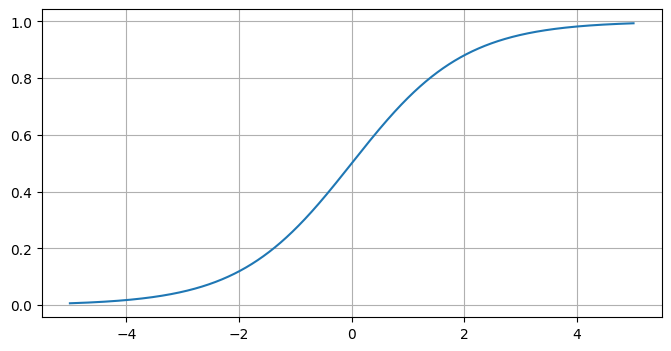

In [53]:
plt.figure(figsize=(8, 4))
plt.plot(xvals, yvals)
plt.grid()
plt.show()

## Hyperbolic tangent

In [54]:
def plot_activation_fn(fn):
    xvals = np.arange(-5, 5, 0.0001)
    yvals = fn(xvals)
    plt.figure(figsize=(8, 4))
    plt.plot(xvals, yvals)
    plt.grid()
    plt.show()

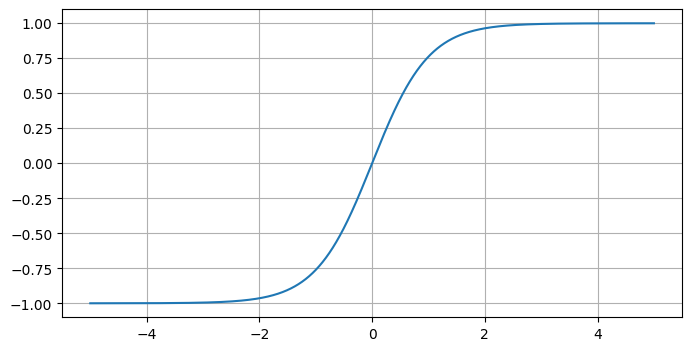

In [55]:
plot_activation_fn(np.tanh)

## ReLU(Rectified Linear Unit)

*   입력값이 양수이면 마치 활성화 함수가 없는 것처럼 입력값 그대로 출력으로 내보냄.
*   입력값이 음수이면 출력값을 0으로 만듦.
*   이미지 처리를 할 때 좋은 성능을 낸다고 알려져 있음.

$
\text{ReLU}(x) =
\begin{cases}
    x & \text{for } x \ge 0 \\
    0 & \text{for } x \lt 0
\end{cases}
$

In [56]:
def relu(x):
    return np.maximum(x, 0)

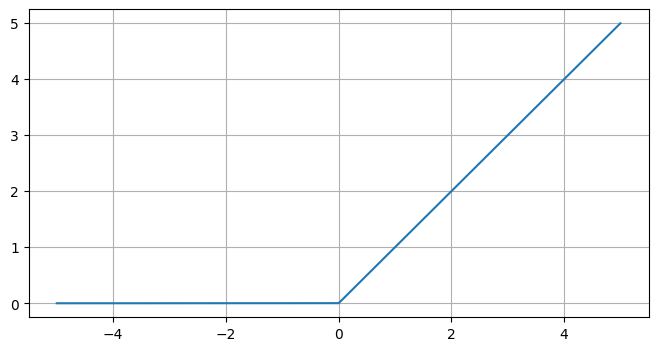

In [57]:
plot_activation_fn(relu)

## Leaky ReLU

$
\text{LeakyReLU}(x, \alpha) =
\begin{cases}
    x & \text{for } x \ge 0 \\
    \alpha x & \text{for } x \lt 0
\end{cases}
$

In [58]:
def leaky_relu(x, alpha=0.1):
    # 0 <= alpha <= 1
    return np.maximum(x, alpha * x)

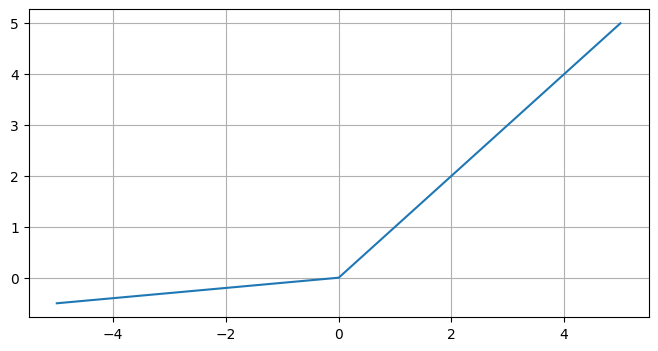

In [59]:
plot_activation_fn(leaky_relu)

## ELU(Exponential Linear Unit)

$
\text{ELU}(x, \alpha) =
\begin{cases}
    x & \text{for } x \ge 0 \\
    \alpha (\exp(x) - 1) & \text{for } x \lt 0
\end{cases}
$

In [60]:
def elu(arr, alpha=1):
    # 0 <= alpha
    result = []
    for x in arr:
        if x >= 0:
            result.append(x)
        else:
            result.append(alpha * (np.exp(x) - 1))
    return np.array(result)

In [61]:
def elu(x, alpha=1):
    return np.where(x >= 0, x, alpha * (np.exp(x) - 1))

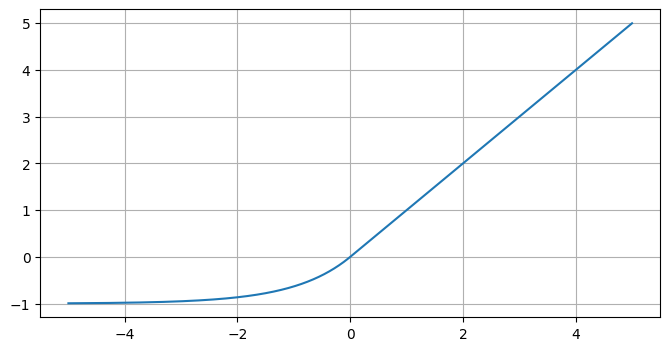

In [62]:
plot_activation_fn(elu)

은닉층에서의 활성화 함수 선택: ELU > LeakyReLU > ReLU > tanh > sigmoid

## ReLU를 활성화 함수로 사용하는 은닉층

In [63]:
model = keras.Sequential()

In [64]:
model.add(keras.Input(shape=(28, 28)))  # 입력층

In [65]:
model.add(keras.layers.Flatten())  # (28, 28) shape의 배열을 (784,) shape으로 변환

In [66]:
# 100개 unit을 갖는, ReLU를 활성화 함수로 사용하는 은닉층을 추가
model.add(keras.layers.Dense(units=100, activation='relu'))

In [67]:
# 출력층 - 다중 클래스 분류. 10개의 unit을 갖고 softmax를 활성화 함수로 사용하는 층.
model.add(keras.layers.Dense(units=10, activation='softmax'))

In [68]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
# 모델 컴파일
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [70]:
# 모델 훈련
model.fit(x=train_data_scaled, y=train_target, epochs=5)

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.6674 - sparse_categorical_accuracy: 0.7667
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4059 - sparse_categorical_accuracy: 0.8533
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3596 - sparse_categorical_accuracy: 0.8681
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.3321 - sparse_categorical_accuracy: 0.8772
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3154 - sparse_categorical_accuracy: 0.8862


In [71]:
# 모델 평가 - 훈련 셋의 손실/정확도
model.evaluate(x=train_data_scaled, y=train_target)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2777 - sparse_categorical_accuracy: 0.8992


[0.28193235397338867, 0.8992708325386047]

In [72]:
# 모델 평가 - 검증 셋의 손실/정확도
model.evaluate(x=val_data_scaled, y=val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3334 - sparse_categorical_accuracy: 0.8801


[0.3279176950454712, 0.8840000033378601]

## ELU를 활성화 함수로 사용하는 은닉층

In [73]:
model = keras.Sequential()
model.add(keras.Input(shape=(28, 28)))  # 입력층
model.add(keras.layers.Flatten())  # Flatten layer: 2차원 입력 배열 -> 1차원 배열
model.add(keras.layers.Dense(units=100, activation='elu'))  # 은닉층(hidden layer)
model.add(keras.layers.Dense(units=10, activation='softmax'))  # 출력층

In [74]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

In [75]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [76]:
model.fit(x=train_data_scaled, y=train_target, epochs=5)

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6699 - sparse_categorical_accuracy: 0.7652
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4109 - sparse_categorical_accuracy: 0.8533
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3677 - sparse_categorical_accuracy: 0.8660
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.3386 - sparse_categorical_accuracy: 0.8800
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.3166 - sparse_categorical_accuracy: 0.8857


In [77]:
model.evaluate(x=train_data_scaled, y= train_target)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3086 - sparse_categorical_accuracy: 0.8853


[0.31055739521980286, 0.8852291703224182]

In [78]:
model.evaluate(x=val_data_scaled, y=val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3414 - sparse_categorical_accuracy: 0.8718


[0.34286966919898987, 0.8765000104904175]

# Optimizer

*   경사 하강법(Gradient Descent)
    *   손실 함수를 최소로 만드는 가중치들을 찾는 방법.

$
w_{next} = w_{init} - 학습률 \cdot 기울기
$

*   아주 큰 신경망인 경우는 모델 훈련을 통해서 찾아야 하는 모델 파라미터들의 개수가 매우 많음.
*   모델 파라미터들의 개수가 많을 수록 훈련 속도가 심각하게 느려질 수 있음.
*   훈련 속도를 높이는 방법:
    *   좋은 초기화 전략 사용하기
    *   좋은 활성화 함수 사용하기
    *   배치 정규화 사용하기
    *   사전 훈련된 네트워크(신경망)의 일부를 재사용.
    *   일반적인 경사 하강법 대신 더 빠른 옵티마이저를 사용하기.
*   확률적 경사 하강법(SGD)의 변종 옵티마이저
    *   학습률(learning_rate) 파라미터를 변경.
    *   모멘텀 최적화(momentum optimization): 모멘텀(momentum) 파라미터 값을 0보다 큰 값으로 변경.
    *   네스테로프 가속 경사(Nesterov Accelerated Gradient, NAG): nesterov 파라미터를 True로 설정.
*   적응형 학습률(adaptive learning rate): 학습할 때마다 학습률을 변화시킴.
    *   RMSprop(Root Mean Squared Propagation): Sequential 클래스의 compile 메서드의 optimizer 기본값.
    *   Adam(Adaptive Momentum Estimation): 모멘텀 최적화 + RMSprop
    *   Nadam: Adam + Nesterov
    *   AdaGrad

## SGD optimizer

In [79]:
def create_model(layers=None):
    # layers: keras.layers 객체들의 배열/리스트.
    model = keras.Sequential()  # Seqential 모델 생성
    model.add(keras.Input(shape=(28, 28)))  # 입력층 추가
    model.add(keras.layers.Flatten())  # Flatten layer 추가
    model.add(keras.layers.Dense(units=100, activation='relu'))  # 첫번째 은닉층을 추가
    if layers:  # 아규먼트로 전달된 은닉층들이 있으면
        for layer in layers:
            model.add(layer)
    model.add(keras.layers.Dense(units=10, activation='softmax'))  # 출력층 추가

    return model

In [80]:
model = create_model()

In [81]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
# 옵티마이저: 학습률 변경, 모멘텀 최적화, 네스테로프 가속 경사
op = keras.optimizers.SGD(learning_rate=0.02, momentum=0.1, nesterov=True)
model.compile(optimizer=op,
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [83]:
model.fit(x=train_data_scaled, y=train_target, epochs=5)

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.8810 - sparse_categorical_accuracy: 0.7041
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.5035 - sparse_categorical_accuracy: 0.8249
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4537 - sparse_categorical_accuracy: 0.8416
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4277 - sparse_categorical_accuracy: 0.8461
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.4048 - sparse_categorical_accuracy: 0.8559


In [84]:
model.evaluate(x=train_data_scaled, y=train_target)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3718 - sparse_categorical_accuracy: 0.8705


[0.37861043214797974, 0.8685625195503235]

In [85]:
model.evaluate(x=val_data_scaled, y=val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3907 - sparse_categorical_accuracy: 0.8624


[0.38601797819137573, 0.8649166822433472]

## Adam optimizer

*   `learning_rate` 파라미터: 학습률
*   `beta_1`, `beta_2` 파라미터: 모멘텀 최적화와 관련된 파라미터.
*   `epsilon` 파라미터: 적응형 학습률과 관련된 파라미터.

In [86]:
model = create_model()

In [87]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [88]:
model.fit(x=train_data_scaled, y=train_target, epochs=5)

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.6844 - sparse_categorical_accuracy: 0.7610
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4050 - sparse_categorical_accuracy: 0.8562
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.3679 - sparse_categorical_accuracy: 0.8656
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3298 - sparse_categorical_accuracy: 0.8814
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3152 - sparse_categorical_accuracy: 0.8850


In [89]:
model.evaluate(x=train_data_scaled, y=train_target)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2816 - sparse_categorical_accuracy: 0.8964


[0.2856843173503876, 0.8962916731834412]

In [90]:
model.evaluate(x=val_data_scaled, y=val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3371 - sparse_categorical_accuracy: 0.8807


[0.3335145115852356, 0.8845833539962769]

# 모델 훈련

In [91]:
model = create_model()  # 은닉층 1개를 갖는 모델을 생성
model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_accuracy])  # 모델 컴파일

In [92]:
result = model.fit(x=train_data_scaled, y=train_target, epochs=5,
                   validation_data=[val_data_scaled, val_target])

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6717 - sparse_categorical_accuracy: 0.7661 - val_loss: 0.4422 - val_sparse_categorical_accuracy: 0.8437
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4024 - sparse_categorical_accuracy: 0.8566 - val_loss: 0.3827 - val_sparse_categorical_accuracy: 0.8612
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3581 - sparse_categorical_accuracy: 0.8690 - val_loss: 0.3582 - val_sparse_categorical_accuracy: 0.8711
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.3360 - sparse_categorical_accuracy: 0.8796 - val_loss: 0.3424 - val_sparse_categorical_accuracy: 0.8822
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3217 - sparse_categorical_accuracy: 0.8829 - val_loss: 0.3399 - val_sparse_categorical_accuracy: 0.8870


## History 객체

신경망 모델을 훈련(fit)시키는 과정(각각의 epoch)의 기록을 담고 있는 객체. fit 메서드의 리턴 값.

In [93]:
type(result)

keras.src.callbacks.history.History

In [94]:
type(result.history)

dict

In [95]:
hist = result.history
# 각 epoch마다 훈련 셋 손실/정확도, 검증 셋 손실/정확도를 dict로 저장.

In [96]:
hist.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

In [97]:
hist.items()

dict_items([('loss', [0.534455418586731, 0.3985402286052704, 0.36203980445861816, 0.33788469433784485, 0.32108110189437866]), ('sparse_categorical_accuracy', [0.8117916584014893, 0.8575624823570251, 0.867229163646698, 0.8786041736602783, 0.8846458196640015]), ('val_loss', [0.44222161173820496, 0.3826885521411896, 0.35817936062812805, 0.34235677123069763, 0.33992698788642883]), ('val_sparse_categorical_accuracy', [0.843666672706604, 0.8611666560173035, 0.8710833191871643, 0.8821666836738586, 0.8870000243186951])])

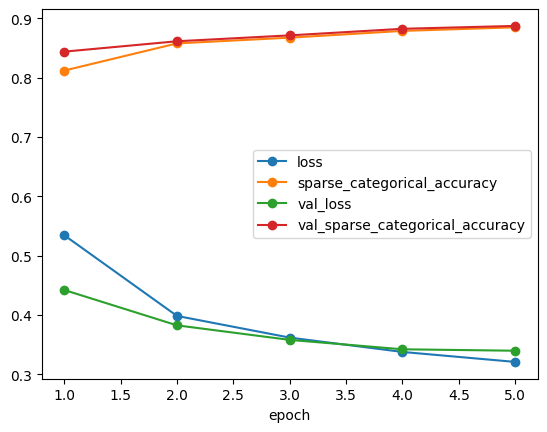

In [98]:
epochs = np.arange(1, 6)
for k, v in hist.items():
    plt.plot(epochs, v, 'o-', label=k)
plt.legend()
plt.xlabel('epoch')
plt.show()

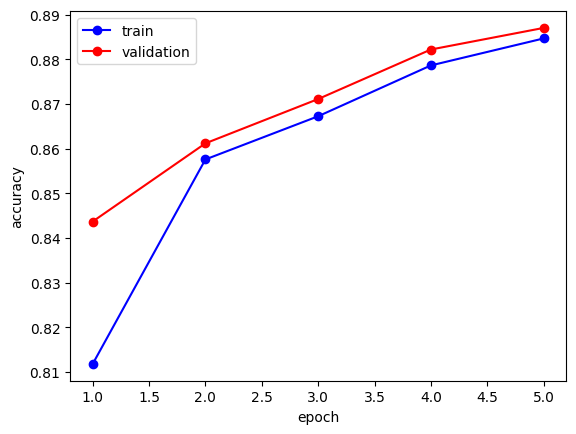

In [99]:
# 정확도 그래프
plt.plot(epochs, hist['sparse_categorical_accuracy'], 'bo-', label='train')
plt.plot(epochs, hist['val_sparse_categorical_accuracy'], 'ro-', label='validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

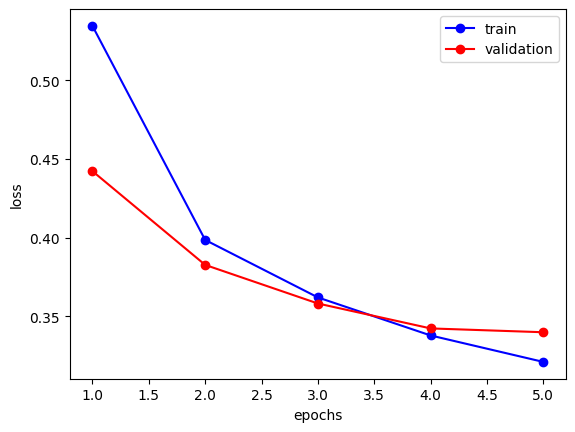

In [100]:
# 손실 그래프
plt.plot(epochs, hist['loss'], 'bo-', label='train')
plt.plot(epochs, hist['val_loss'], 'ro-', label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## RMSprop 옵티마이저 사용

*   100개의 unit으로 이루어진 은닉층 1개를 갖는 신경망 모델 생성
*   RMSprop 옵티마이저를 사용하도록 모델을 컴파일
*   epoch 횟수를 20회로 모델을 훈련시키고 그 결과를 저장.
*   History 객체의 history 속성을 사용해서 훈련 셋과 검증 셋의 손실 그래프를 그려 보세요.

In [101]:
model = create_model()
model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_accuracy])
result = model.fit(x=train_data_scaled, y=train_target, epochs=20,
                   validation_data=[val_data_scaled, val_target])

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6806 - sparse_categorical_accuracy: 0.7630 - val_loss: 0.4056 - val_sparse_categorical_accuracy: 0.8554
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4062 - sparse_categorical_accuracy: 0.8529 - val_loss: 0.4157 - val_sparse_categorical_accuracy: 0.8520
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3591 - sparse_categorical_accuracy: 0.8727 - val_loss: 0.3408 - val_sparse_categorical_accuracy: 0.8816
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3349 - sparse_categorical_accuracy: 0.8792 - val_loss: 0.3457 - val_sparse_categorical_accuracy: 0.8815
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3188 - sparse_categorical_accuracy: 0.8856 - val_loss: 0.3477 - val_sparse_categorical_accuracy: 0.8831
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3083 - sparse_categorical_accuracy: 0.8884 - val_loss: 0.3321 - val_sparse_categorical_accuracy:

In [102]:
epochs = np.arange(1, 21)

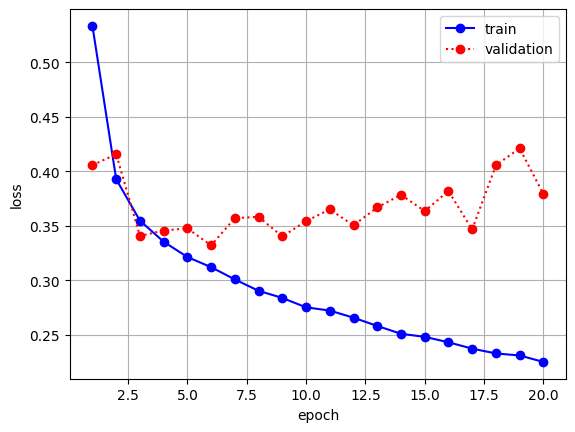

In [103]:
history = result.history
plt.plot(epochs, history['loss'], 'bo-', label='train')
plt.plot(epochs, history['val_loss'], 'ro:', label='validation')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

epoch를 5번 이상 실행하면 과대적합의 크기만 더 커짐.

## Adam 옵티마이저 사용

*   위의 과정을 반복

In [104]:
model = create_model()
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_accuracy])
result = model.fit(x=train_data_scaled, y=train_target, epochs=20,
                   validation_data=[val_data_scaled, val_target])

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6936 - sparse_categorical_accuracy: 0.7585 - val_loss: 0.4275 - val_sparse_categorical_accuracy: 0.8472
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4103 - sparse_categorical_accuracy: 0.8572 - val_loss: 0.3861 - val_sparse_categorical_accuracy: 0.8590
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3578 - sparse_categorical_accuracy: 0.8702 - val_loss: 0.3466 - val_sparse_categorical_accuracy: 0.8774
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3274 - sparse_categorical_accuracy: 0.8792 - val_loss: 0.3221 - val_sparse_categorical_accuracy: 0.8863
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.3053 - sparse_categorical_accuracy: 0.8878 - val_loss: 0.3218 - val_sparse_categorical_accuracy: 0.8853
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2874 - sparse_categorical_accuracy: 0.8912 - val_loss: 0.3410 - val_sparse_categorical_accuracy:

In [105]:
def plot_train_val_losses(history):
    plt.plot(history.epoch, history.history['loss'], 'bo-', label='train')
    plt.plot(history.epoch, history.history['val_loss'], 'ro:', label='validation')
    plt.grid()
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

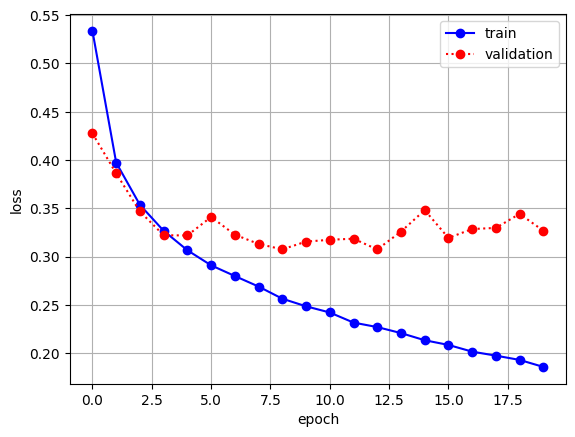

In [106]:
plot_train_val_losses(result)

epoch를 6번 이상 수행하더라도 검증 셋의 손실이 더 이상 작아지지 않음.

# Dropout

*   훈련 과정(epoch)에서 일부 unit의 출력을 0으로 만드는 것(그 다음 layer로 출력값을 전달하지 않음).
*   각 epoch마다 출력을 0으로 만드는 unit은 무작위로 선택.
*   모델의 과대적합을 줄일 수 있음.

In [107]:
model = create_model(layers=[keras.layers.Dropout(rate=0.3)])
# 은닉층 뒤에 30% 비율로 출력을 0으로 만드는 Dropout 계층을 추가

In [108]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

In [109]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [110]:
result = model.fit(x=train_data_scaled, y=train_target, epochs=20,
                   validation_data=[val_data_scaled, val_target])

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7766 - sparse_categorical_accuracy: 0.7285 - val_loss: 0.4085 - val_sparse_categorical_accuracy: 0.8533
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.4465 - sparse_categorical_accuracy: 0.8390 - val_loss: 0.3912 - val_sparse_categorical_accuracy: 0.8586
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4015 - sparse_categorical_accuracy: 0.8547 - val_loss: 0.3707 - val_sparse_categorical_accuracy: 0.8633
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3878 - sparse_categorical_accuracy: 0.8583 - val_loss: 0.3439 - val_sparse_categorical_accuracy: 0.8730
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3700 - sparse_categorical_accuracy: 0.8646 - val_loss: 0.3330 - val_sparse_categorical_accuracy: 0.8800
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3570 - sparse_categorical_accuracy: 0.8707 - val_loss: 0.3317 - val_sparse_categorical_accuracy:

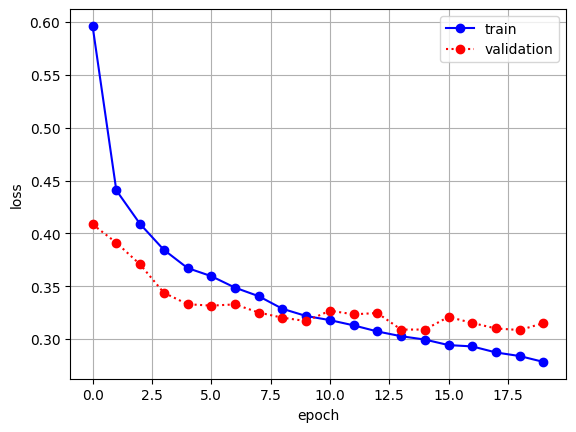

In [111]:
plot_train_val_losses(result)

# 모델 저장과 복원

In [112]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 238,532 (931.77 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 159,022 (621.18 KB)

In [114]:
len(model.weights)

4

In [116]:
model.weights[0]  #> (784, 100) shape. 첫번째 은닉층에서 학습된 가중치들.

<Variable path=sequential_8/dense_15/kernel, shape=(784, 100), dtype=float32, value=[[ 0.0311612   0.02474512 -0.1131414  ... -0.09337743  0.02836364
   0.2748005 ]
 [-0.06125542 -0.1191967   0.10989875 ...  0.08489571  0.09814743
   0.2815332 ]
 [ 0.0950825  -0.6712331  -0.37240618 ...  0.09725031 -0.18065187
   0.16204311]
 ...
 [ 0.35616606  0.41825148  0.07191543 ... -0.21038239  0.05998271
   0.08008796]
 [ 0.28294298 -0.14392619  0.20804854 ...  0.02941484  0.5561869
  -0.03039658]
 [ 0.2920062   0.09623046  0.06433321 ...  0.18975934  0.34755543
  -0.03148513]]>

In [117]:
model.weights[1]  #> (100,) shape. 첫번째 은닉층에서 학습된 bias들.

<Variable path=sequential_8/dense_15/bias, shape=(100,), dtype=float32, value=[ 0.36107495 -0.10711242 -0.1276333   0.63142204  0.83686453 -0.05335209
  0.16255489  0.27351585  0.29867095 -0.46988565 -0.1442392  -0.11912777
  0.41429195  0.35813808 -0.01616238  0.2068076   0.18578906  0.06685238
 -0.42856598  0.02283224  0.14234471  0.26091522  0.03007323  0.59001654
  0.01399006  0.17586216  0.6832942   0.31804234  0.04303218 -0.35177225
 -0.18758968 -0.01083554  1.1417466   0.7110643   0.3441171   0.05778435
  0.39183939  0.08360377 -0.01611319 -0.08134063  0.66213983 -0.16285078
  0.22012919  0.44437063 -0.34891266 -0.02790909 -0.01543996 -0.64048326
  0.03445339  0.52747107 -0.07735454  0.7370489   0.11432719 -0.52311844
  0.57129526  0.61241305  0.2942868   0.6480168  -0.2892      0.01356498
 -0.02077862  0.09892176  0.05122189 -0.01066572  1.1531146   0.21046366
 -0.0601856  -0.01575682  0.32869357  0.4074973   0.86521274  0.7221421
  0.37179145 -0.02190283 -0.06824738  0.7863558

In [118]:
 model.weights[2]  #> (100, 10) shape. 출력층에서 학습된 가중치들.

<Variable path=sequential_8/dense_16/kernel, shape=(100, 10), dtype=float32, value=[[ 2.05018684e-01  3.02939802e-01 -7.03896701e-01 -9.50648189e-02
  -3.85333717e-01 -4.96434033e-01 -1.71728477e-01  4.58886683e-01
  -1.38745621e-01 -6.02244973e-01]
 [-2.53636479e-01  3.61303866e-01  2.22720146e-01 -5.63839912e-01
   2.30590239e-01 -3.34133096e-02  8.27048495e-02 -9.90413249e-01
  -5.37344694e-01  1.17707830e-02]
 [ 1.30277172e-01  3.33926417e-02  1.42550483e-01  1.42890558e-01
   2.80192077e-01  2.62216330e-01 -7.53991529e-02 -1.02269888e-01
   3.41557801e-01 -3.65395725e-01]
 [ 3.08409780e-01  2.11841628e-01 -9.42124844e-01  5.76938204e-02
  -4.48239774e-01  4.02708292e-01  8.35821182e-02 -8.32217813e-01
   3.36961336e-02 -7.00146556e-01]
 [ 6.37788996e-02 -1.03913295e+00  1.03582971e-01  2.06854180e-01
  -8.64191875e-02  1.56027555e-01  1.49925247e-01 -1.16830565e-01
  -5.62561929e-01 -4.61455882e-01]
 [-5.08678198e-01  3.77730221e-01 -1.32109568e-01 -1.86084852e-01
  -5.30280583e-0

In [119]:
model.weights[3]  #> (10,) shape. 출력층에서 학습된 bias들.

<Variable path=sequential_8/dense_16/bias, shape=(10,), dtype=float32, value=[ 0.02758506 -0.71619445  0.11475127  0.355211   -0.08064951 -0.38270083
  0.23658161  0.2518074  -0.01934446 -0.6930058 ]>

## 모델 저장

In [120]:
path = '/content/drive/MyDrive/Colab Notebooks/lab_da'

# 모델 파라미터들만 저장하는 파일의 확장자는 '.weights.h5'
weights_file = path + '/model1.weights.h5'

# 훈련이 끝난 모델을 저장하는 파일의 확장자는 '.keras'
model_file = path + '/model1.keras'

In [121]:
# 모델 파라미터들만 저장
model.save_weights(weights_file)

In [122]:
# 모델의 구조와 모델 파라미터들을 함께 저장
model.save(model_file)

## 파일에 저장된 모델을 복원

### 모델 파라미터들만 저장한 파일(weights.h5)에서 복원

In [123]:
# 모델 파라미터와 같은 구조로 모델을 먼저 생성.
model = create_model(layers=[keras.layers.Dropout(rate=0.3)])

In [124]:
# 생성된 모델에서 load_weights 메서드 호출, 아규먼트는 저장된 가중치 파일.
model.load_weights(weights_file)

모델 파라미터들만 복원한 경우에는 모델이 컴파일되어 있지 않은 상태이기 때문에 `evaluate()` 메서드를 호출할 수 없음. 모델 파라미터(가중치들)들은 모두 복원이 됐기 때문에 `predict()` 메서드는 호출 가능.

In [126]:
predicts = model.predict(x=train_data_scaled)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [127]:
predict_labels = predicts.argmax(axis=1)

In [128]:
accuracy_score(train_target, predict_labels)

0.9128958333333334

### 모델 구조와 파라미터들을 저장한 파일(keras)에서 모델을 복원

In [129]:
# keras.models.load_model() 함수 호출, 모델을 저장할 파일(.keras)을 아규먼트로 줌.
model = keras.models.load_model(model_file, compile=True)

확장자가 .keras인 파일에서 모델을 복원하는 경우는 컴파일이 끝난 모델을 복원함. `evaluate()` 메서드와 `predict()` 메서드들을 모두 사용할 수 있음.

In [130]:
model.evaluate(x=train_data_scaled, y=train_target)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2290 - sparse_categorical_accuracy: 0.9115


[0.23035632073879242, 0.9128958582878113]

# Callback

*   callback(콜백): 훈련 과정 중간에 어떤 작업을 수행할 수 있게 만드는 객체. `keras.callbacks` 모듈 아래의 클래스들을 사용할 수 있음.
*   `keras.callbacks.ModelCheckpoint` 클래스
    *   epoch마다 모델을 저장할 수 있는 기능을 가지고 있는 클래스.
    *   `save_best_only` 파라미터를 True로 설정해서 가장 검증 손실이 작은 모델만을 저장할 수 있음.
*   `keras.callbacks.EarlyStopping` 클래스
    *   과대적합이 시작되기 전에 훈련을 일찍 종료시킬 수 있는 기능을 가지고 있는 클래스.
    *   `fit()` 메서드에서 설정된 epochs 횟수보다 일찍 모델 훈련이 종료될 수 있음.

In [137]:
# 모델 생성
model = create_model(layers=[keras.layers.Dropout(rate=0.3)])

In [138]:
# 모델 컴파일
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [139]:
# 모델체크포인트 콜백 객체 생성
checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=path + '/best_model.keras',
                                                save_best_only=True)

In [140]:
# 조기종료 콜백 객체 생성
early_stop_cb = keras.callbacks.EarlyStopping(patience=3,
                                              restore_best_weights=True)

In [141]:
# 검증 셋과 콜백들을 설정해서 모델을 훈련
result = model.fit(x=train_data_scaled, y=train_target, epochs=100,
                   callbacks=[checkpoint_cb, early_stop_cb],
                   validation_data=[val_data_scaled, val_target])

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7692 - sparse_categorical_accuracy: 0.7320 - val_loss: 0.4149 - val_sparse_categorical_accuracy: 0.8493
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.4539 - sparse_categorical_accuracy: 0.8347 - val_loss: 0.3740 - val_sparse_categorical_accuracy: 0.8618
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.4112 - sparse_categorical_accuracy: 0.8517 - val_loss: 0.3609 - val_sparse_categorical_accuracy: 0.8652
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3822 - sparse_categorical_accuracy: 0.8590 - val_loss: 0.3445 - val_sparse_categorical_accuracy: 0.8738
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3707 - sparse_categorical_accuracy: 0.8643 - val_loss: 0.3351 - val_sparse_categorical_accuracy: 0.8783
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.3623 - sparse_categorical_accuracy: 0.8682 - val_loss: 0.3276 - val_sparse_categorical_acc

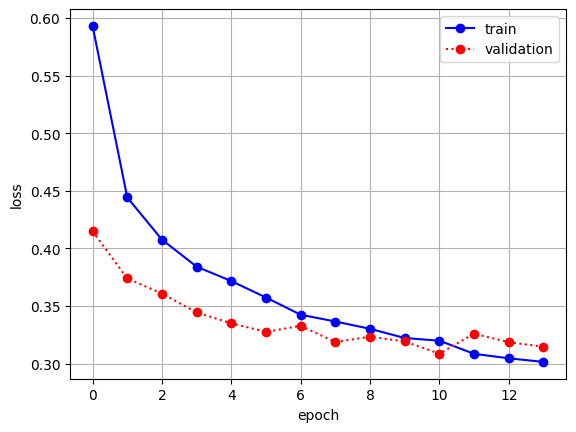

In [142]:
plot_train_val_losses(result)

In [143]:
# 훈련이 끝난 모델 평가
model.evaluate(x=train_data_scaled, y=train_target)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2555 - sparse_categorical_accuracy: 0.9026


[0.25822713971138, 0.9037291407585144]

In [144]:
model.evaluate(x=val_data_scaled, y=val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3068 - sparse_categorical_accuracy: 0.8857


[0.30873599648475647, 0.8891666531562805]

In [145]:
# 최적의 파라미터들과 모델 구조를 저장할 파일에서 모델을 복원
best_model = keras.models.load_model(filepath=path + '/best_model.keras')

In [146]:
best_model.evaluate(x=train_data_scaled, y=train_target)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2555 - sparse_categorical_accuracy: 0.9026


[0.25822713971138, 0.9037291407585144]

In [147]:
best_model.evaluate(x=val_data_scaled, y=val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3068 - sparse_categorical_accuracy: 0.8857


[0.30873599648475647, 0.8891666531562805]